# Statistical validation of FIES data (Rasch Model)

Before we can use the FIES data for urban food insecurity indicator, they need to be _statistically_ validated to make sure that the prevalence estimates we produce are valid and reliable.

The analysis of FIES data involves:

1. **Parameter estimation**: To calculate the level of food insecurity severity associated with each question and each respondent.
2. **Statistical Validation**: To assess whether, depending on the quality of the data collected, the measure is valid.
3. **Calculation of food insecurity prevalence estimates**: To calculate a measure of severity of the food insecurity condition experienced by each respondent, based on their answers to the eight FIES questions. This is then used to estimate the prevalence of food insecurity at moderate and/or
severe levels in the population.

## FIES analysis methodology (Rasch Model)
Item Response Theory (IRT) is a methodology used to analyse responses to survey or test questions.
The Rasch model is one of several models in IRT and is applied for the analysis of FIES data. Item response theory aims to improve the measurement accuracy and reliability of surveys and tests through analysis of response data. The item response theory (IRT) measurement model known as the `Rasch` model provides a theoretical base and a set of statistical tools to:

* assess the suitability of a set of survey items for scale construction
* create a scale from the items, and compare performance of a scale in various populations and survey contexts.

The Rasch model is expressed mathematically as :


$$Prob(x_{h,i} = 1|θ_h, β_i) =  \frac {e^{θ_h - β_i}}{1 + e^{θ_h - β_i}}$$

_where $x_{ℎ,𝑖}$ is the response given by respondent *h* to item *i*, coded as 1 for “yes” and 0 for “no”.
The relative severity associated with each of the experiences (the parameters $β_i$
in the formula above) can be inferred from the frequency with which they are reported by a large sample of respondents,  assuming that, all else being equal, more severe experiences are reported by fewer respondents. 
Once the severity of each experience is estimated, the severity of a respondent’s condition (the 𝜃ℎ parameter) can be computed by noting how many of the items have been affirmed._


### Assumptions of the Rasch model
The Rasch model is based upon four key assumptions:
* Only one dimension is represented by the response data. For the FIES, this is the access dimension
of food security
* An individual’s responses to the eight FIES items are correlated with each other only because they are all conditioned by the severity of food insecurity of that individual.
* The greater the severity of food insecurity experienced by a respondent, the higher the likelihood that he or she will respond affirmatively to each item
* All items are equally strongly related to the latent trait of food insecurity and differ only in severity. ie All items discriminate equally

### Relative Scale
<center>
<img src="../assets/fies_relative_scale.png" width="500" />
<figcaption style="font-size: 10px; font-style: italic;">Fig. 1: Relative scale of severity</figcaption>
</center>



## Preparing the data for analysis
To prepare the data collected through the FIES survey module for analysis, each item should be
coded, so that: 0 is used for a "no" response; 1 is used for a "yes" response.

The FIES survey module allows recording of **"don't know" and "refused"** responses to
any of the FIES items. For our analytic purposes, such answers are treated as "missing" and
cases with missing responses for any of the FIES items are excluded from the analysis.

**Important Terminologies**
For the purpose of FIES analysis, the term **item** will refer to the **questions** in the survey module.
- A **respondent** is an individual or household responding to the items.
- A **case** is the unit for which data are collected and appear in a dataset.
- A **parameter** is a numerical quantity that characterizes a given population or some aspect of it, and
that can be estimated using observed data.

In the case of the FIES, parameters express the severity of food insecurity of both:
* the FIES questions (**item parameters**);
* the people who answer them (**respondent parameters**). 

Now that we understand how the **items** and **respondents** each have a place along the scale of severity.
The next step is to estimate their parameters to determine their exact location.

In [2]:
## Import Libraries and load data
import pandas as pd
import numpy as np
import re

In [3]:


# Load FIES data for Urban Population ONLY
df_all = pd.read_csv("../processed_data/hh_fies_df.csv")

print(df_all.area.value_counts())

df = df_all.loc[df_all["area"] == "URBAN"].reset_index(drop=True)

df.shape



area
RURAL    22804
URBAN    10827
Name: count, dtype: int64


(10827, 33)

In [3]:
### Saving the FIES data and corresponding weights

# select fies columns"
fies_cols = [col for col in df.columns if re.search(r'^(fe)\d+$', col)]
fies_data = df.loc[:, fies_cols]


### Calculate raw scores (number of yes for each individual to the 8 questions)
fies_data = fies_data.assign(fies_score = fies_data[fies_cols].sum(axis="columns"))


### Number of items (questions) of the FIES
k = len(fies_data)
print("Number of items (questions) in the FIES:", k)

# Saving the FIES data and corresponding weights
fies_data_wt = df["hhweightmics"]

# Dictionary mapping Food Insecurity Experience Scale (FIES) item codes to their descriptive names
fies_dict = {
    "fe1": "WORRIED",
    "fe2": "HEALTHY",
    "fe3": "FEWFOOD",
    "fe4": "SKIPPED",
    "fe5": "ATELESS",
    "fe6": "RANOUT",
    "fe7": "HUNGRY",
    "fe8": "WHLDAY",
}

# Rename columns
fies_data = fies_data.rename(columns=fies_dict)
fies_data = pd.concat([fies_data, fies_data_wt], axis=1)

# Save the output to a csv file
fies_data.to_csv("../processed_data/fies_rasch_urban.csv", index=False)
print(fies_data.shape)
fies_data.head()



Number of items (questions) in the FIES: 10827
(10827, 10)


,WORRIED,HEALTHY,FEWFOOD,SKIPPED,ATELESS,RANOUT,HUNGRY,WHLDAY,fies_score,hhweightmics
0,1,1,1,1,1,1,1,0,7,0.61955
1,1,1,1,1,1,1,0,0,6,0.61955
2,1,0,0,1,1,1,1,0,5,0.61955
3,0,1,1,1,1,1,1,1,7,0.61955
4,1,1,1,1,1,1,1,0,7,0.61955


In [4]:
10827-10680


147

In [4]:
fies_data.isna().sum()

WORRIED         0
HEALTHY         0
FEWFOOD         0
SKIPPED         0
ATELESS         0
RANOUT          0
HUNGRY          0
WHLDAY          0
fies_score      0
hhweightmics    0
dtype: int64

### Set up Jupyter to write R code

In [4]:
## Import the function for importing R packages in Python
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import rpy2.robjects as ro

# Load the rpy2.ipython extension to use R magic commands in Jupyter notebooks
%load_ext rpy2.ipython
pandas2ri.activate()

In [5]:
%%R
library(tidyverse)
library(TAM)
library(WrightMap)
if(!require('RM.weights')) {
  install.packages('RM.weights')
  library('RM.weights')
}

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.3
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: CDM
Loading required package: mvtnorm
**********************************
** CDM 8.2-6 (2022-08-25 15:43:23)       
** Cognitive Diagnostic Models  **
**********************************

* TAM 4.1-4 (2022-08-28 16:03:54)
Loading required package: RM.weights
Loading required package: psychotools
Loading required package: Hmisc

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:dplyr’:

    src, summarize

The following objects are masked from ‘package:base’:

    format.pval, units



### Psychometric analysis


#### **Estimating the item parameters**

The item parameter is estimated based on the overall pattern of responses given by all
respondents. A question representing a less severe experience will have a smaller parameter value,
whereas a question representing a more severe experience will have a larger parameter value.

The relative severity of the items is determined based upon the understanding that the more severe
an item is, the less likely respondents are to report it. 

In [6]:
%%R

# Read the CSV file while selecting columns using the regex pattern
fies.ng <- read_csv("../processed_data/fies_rasch_urban.csv")

XX.ng <- fies.ng[,1:8]
wt.ng <- fies.ng$hhweightmics
rr.ng <- RM.w(XX.ng, wt.ng)


fit.descr = tab.weight(wt = wt.ng, XX = XX.ng)

# Display the item severities, standard errors, infits4 and outfits

parameter_estimate <- tibble::rownames_to_column(
  data.frame(
    "Item Severity" = rr.ng$b,      # Item severity estimate
    "Stardard Error" = rr.ng$se.b,  # Item standard error
    "Infit" = rr.ng$infit,           # Infit
    "Outfit" = rr.ng$outfit,
    "Weighted perc. of Yes" = fit.descr$Perc.Yes.w,
    "Unweighted perc. of Yes" = fit.descr$Perc.Yes
  ),
  var = "Item"
)

# write the parameter estimates to a CSV file
write.csv(parameter_estimate, "../processed_data/fies_item_parameter_statistics_urban.csv")


Rows: 10827 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (10): WORRIED, HEALTHY, FEWFOOD, SKIPPED, ATELESS, RANOUT, HUNGRY, WHLDA...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
# Output showing the item parameters and the errors associated with each of them
pd.read_csv("../processed_data/fies_item_parameter_statistics_urban.csv", index_col=0)

,Item,Item.Severity,Stardard.Error,Infit,Outfit,Weighted.perc..of.Yes,Unweighted.perc..of.Yes
1,WORRIED,-2.195857,0.054525,1.085374,2.010066,0.76,0.76
2,HEALTHY,-1.254218,0.044594,1.093160,1.784592,0.72,0.72
3,FEWFOOD,-1.243374,0.044501,0.980599,1.657992,0.72,0.72
4,SKIPPED,-0.208792,0.037498,0.905025,0.828380,0.65,0.64
5,ATELESS,-0.777261,0.040908,0.857958,1.081861,0.69,0.69
6,RANOUT,0.643227,0.034604,0.883658,0.877827,0.57,0.57
7,HUNGRY,1.460428,0.034475,0.826726,0.866325,0.48,0.50
8,WHLDAY,3.574856,0.047100,1.081359,2.096552,0.26,0.29


**Observations**

**The higher the severity of an item, the more severe the experience is**. The item `WHLDAY` (eating anything for a whole day because of a lack of money or other resources) has the highest item severity (3.57), representing therefore the most severe experience.


* The item `WHLDAY` has the highest item parameter (3.57 logits) with the lowest affirmative response (26%), 
* Item `WORRIED` had the lowest item parameter (−2.19 logit) and obtained the highest affirmative response (76%).
* `WHLDAY` has the highest severity, implies, of all the items, it received the fewest number of "YES" response (26%).


#### **Estimating the Respondent parameters**

A respondent's **raw score** is the basis for calculating the respondent parameter.
No matter how many respondents are included in a sample, there will always be up to nine distinct
values of respondent parameters, one for each possible raw score (0-8).

> _**raw score**: The raw score is the number of affirmative responses given to the eight FIES questions - it is an
integer number with a value between zero and 8._

An essential point to understand is that every respondent who answers "yes" to the
same number of questions (irrespective of which ones) will be assigned the **same
parameter**. The specific questions affirmed are not used to determine the parameter.

In [8]:

%%R

fit.descr = tab.weight(wt = wt.ng, XX = XX.ng)


# Display the Respondent parameter, 
respondent_param_estimate <- tibble::rownames_to_column(
  data.frame(
    "Respondent Severity" = rr.ng$a,       # Respondent severity for each raw score
    "Stardard Error" = rr.ng$se.a,        # Respondent measurement error for each raw score
    "Abs.RS distrib." = fit.descr$RS.abs.w,
    "weighted Rel.RS distrib." = fit.descr$RS.rel.w*100
  ),
  var = "row_score"
)

respondent_param_estimate$'row_score' <- as.integer(respondent_param_estimate$'row_score') - 1

# write the parameter estimates to a CSV file
write.csv(respondent_param_estimate, "../processed_data/fies_respondent_params_statistics_urban.csv", )


In [9]:
# Display weighted distribution across raw-scores (absolute and relative)
pd.read_csv("../processed_data/fies_respondent_params_statistics_urban.csv", index_col=0)

,row_score,Respondent.Severity,Stardard.Error,Abs.RS.distrib.,weighted.Rel.RS.distrib.
1,0,-3.553509,1.511327,3041.10,19
2,1,-2.717825,1.142284,508.49,3
3,2,-1.707028,0.918332,460.00,3
4,3,-0.915248,0.857817,582.35,4
5,4,-0.304275,0.860974,909.94,6
6,5,0.580177,0.923099,1761.61,11
7,6,1.614144,1.068513,2075.31,13
8,7,2.995950,1.350773,3045.10,19
9,8,4.113990,1.511327,3369.49,21


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In geom_text(aes(x = 1, y = -3.7, label = "MILD"), color = "white",  :
R[write to console]: 
 
R[write to console]:  All aesthetics have length 1, but the data has 9 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.

R[write to console]: 2: 
R[write to console]: In geom_text(aes(x = 7, y = 4.3, label = "SEVERE"), color = "white",  :
R[write to console]: 
 
R[write to console]:  All aesthetics have length 1, but the data has 9 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.



In addition: Warning messages:
1: In geom_text(aes(x = 1, y = -3.7, label = "MILD"), color = "white",  :
  All aesthetics have length 1, but the data has 9 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.
2: In geom_text(aes(x = 7, y = 4.3, label = "SEVERE"), color = "white",  :
  All aesthetics have length 1, but the data has 9 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.


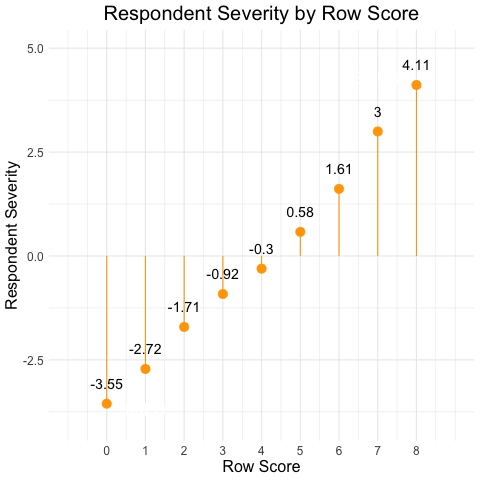

In [10]:
%%R
# Install and load ggplot2 library
# install.packages("ggplot2")
library(ggplot2)

# Create the data frame with the given data
data <- data.frame(
  row_score = 0:8,
  Respondent.Severity = rr.ng$a
)

# Create the plot
plot <- ggplot(data, aes(x = row_score, y = Respondent.Severity)) +
  geom_point(size = 4, color = "orange") +
  geom_segment(aes(x = row_score, xend = row_score, y = 0, yend = Respondent.Severity), color = "orange") +
  geom_text(aes(label = round(Respondent.Severity, 2)), vjust = -1.5, size = 5, color = "black") +
  scale_x_continuous(breaks = 0:8, labels = 0:8, limits = c(-1, 9)) +
  scale_y_continuous(limits = c(-4, 5)) +
  labs(title = "Respondent Severity by Row Score", x = "Row Score", y = "Respondent Severity") +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 20),
    axis.title.x = element_text(size = 16),
    axis.title.y = element_text(size = 16),
    axis.text = element_text(size = 12)
  ) +
  geom_text(aes(x = 1, y = -3.7, label = "MILD"), color = "white", size = 6) +
  geom_text(aes(x = 7, y = 4.3, label = "SEVERE"), color = "white", size = 6)

# Save the plot with specific dimensions
ggsave("../assets/fies_rawscore_respondent_params_plot.png", plot, width = 16, height = 6)
plot


##### Difference between the raw score and the respondent parameter 

Even if expressed by numbers, the raw score only provides an ordinal measure of food insecurity:
the difference in severity between adjacent raw scores is not constant

**Raw Score**

Looking at raw scores only, you can see that a respondent with a raw score of 6 is more food secure
than someone with score of 7 and more food insecure than someone with score of 5.



<center>
<img src="../assets/respondent_params_plot.png" width="700" />
<!-- <figcaption style="font-size: 10px; font-style: italic;">Fig. 1: Relative scale of severity</figcaption> -->
</center>

**Respondent parameter**

Using respondent parameters, we can observe that the difference in severity is smaller between raw
scores 5 and 6 than between 6 and 7.

* Parameters indicate where a person with each raw score will be located along the scale of severity.
* Respondent **parameters** allow us to more precisely evaluate the relative differences in food
insecurity severity along the scale, between the respondents with each raw score.

**For example**

Is it true that a respondent with a raw score of 4 is twice as food insecure as a respondent with a
raw score of 2? It is not true. 

Raw score can only be used as an ordinal measure of food insecurity, meaning that
we know that someone with a raw score of 4 is more food insecure than someone with a raw
score of 2, but we do not know the exact difference in food insecurity severity between these two
respondents. Only the respondent parameter can tell us this, as it is an interval measure of food
insecurity.



In [11]:
# Display respondent parameter output
pd.read_csv("../processed_data/fies_respondent_params_statistics_urban.csv", index_col=0)


,row_score,Respondent.Severity,Stardard.Error,Abs.RS.distrib.,weighted.Rel.RS.distrib.
1,0,-3.553509,1.511327,3041.10,19
2,1,-2.717825,1.142284,508.49,3
3,2,-1.707028,0.918332,460.00,3
4,3,-0.915248,0.857817,582.35,4
5,4,-0.304275,0.860974,909.94,6
6,5,0.580177,0.923099,1761.61,11
7,6,1.614144,1.068513,2075.31,13
8,7,2.995950,1.350773,3045.10,19
9,8,4.113990,1.511327,3369.49,21


#### Distribution of raw score

In [12]:
row_score_df = fies_data["fies_score"].value_counts().to_frame().reset_index()
row_score_df

,fies_score,count
0,8,2476
1,0,2066
2,7,2007
3,6,1362
4,5,1185
5,4,611
6,3,443
7,2,340
8,1,337


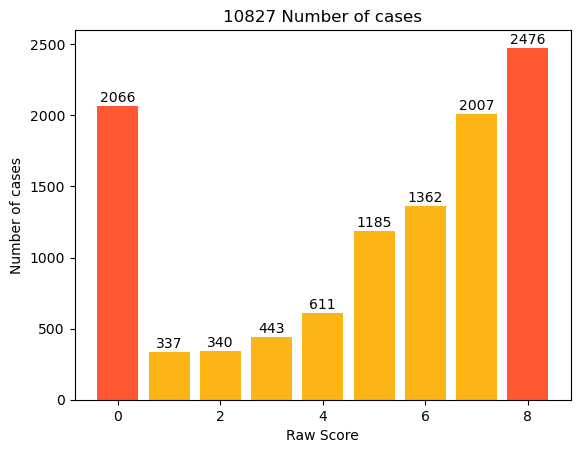

In [13]:
import matplotlib.pyplot as plt

row_score = row_score_df["fies_score"]
count = row_score_df["count"]
# Create a color list to highlight the 0 and 8 scores
colors = ['#FF5733' if x in [0, 8] else '#FDB515' for x in row_score_df["fies_score"]]

# Plot
fig, ax = plt.subplots()

bars = ax.bar(row_score, count, color=colors)

# Add text annotations
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 10, int(yval), ha='center', va='bottom')



# Labels and title
ax.set_xlabel('Raw Score')
ax.set_ylabel('Number of cases')
ax.set_title(f'{count.sum()} Number of cases')

# Show the plot
plt.show()


### Statistical Validation: Assessing data quality

The statistical validation processs is a fundamental screening tool for assessing data quality and for evaluating wheter the a given measure of food insecurity has a solid enough statistical basis for its intended policy and reseach use.

* Determine how well the **FIES** works in the Nigeria.
* Identify problematic items where greater attention to translation and/or survey administration may
be required
* Identify outliers, or respondents with highly unexpected response patterns
* Determine whether the **FIES** does perform differently when administered to different language
groups or culturally distinct subpopulations

#### Interpreting Rasch Model
The Rasch model allows us to produce four results that are useful to test the quality of data
collected. They will help you to identify: 

1. Infit, 
2. Outfit, 
3. Residual correlation matrix and 
4. Model reliability

#### 1.0 Infit Statistics

Items that did not perform well in a particular population

* **LOW (Below 0.7)**:Indication of redundancy.
* **0.7 – 1.3**: An adequate fit to the Rasch model is indicated by infit and outfit statistics of 0.7 – 1.3 for each
item. Test of assumption of equal discrimination. 
* **HIGH (Above 1.3)**: These are items with unexpected response patterns. An item with infit larger than 1.3 is considered to be performing poorly, and should be examined to decide whether to drop it from the scale for the current analysis. 

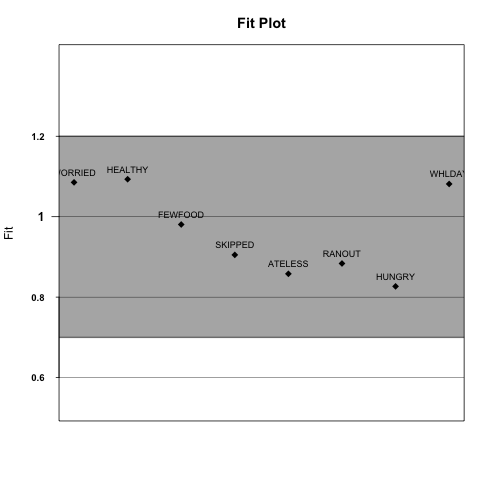

In [14]:
%%R
# Infit
infit <- rr.ng$infit


upper_bound <- rep(x = 1.2, times =8) # this repeats 1.33 fifteen times
lower_bound <- rep(x = .70, times = 8) 

# running fitgraph
fitgraph(fitEst = infit, fitLB = lower_bound, fitUB = upper_bound, itemLabels = names(XX.ng))

**Inference**

In spite of the wide range of cultures and languages in which the FIES-SM was administered
and the attendant challenges of translation, the fit of all the items to the measurement model was remarkably good. 

* _Infit_ statistics for each were between 0.8 and 1.2.
* The highest mean infit (1.15) was for the `HEALTHY` item. The highest infits for 3 of the eight items exceed 1.0.
* The lowest mean infits were for `HUNGRY` but did not eat (0.87) and `Ate less than should`

#### 2.0 - Outfit 

While the principle statistic to focus on is **infit**, interpretation of the outfit statistic is also
worthwhile. Outfit statistics have a similar interpretation to the infit statistics, but are sensitive to
the presence of even just a few cases with highly unexpected response patterns, and are therefore
useful to flag the presence of outliers

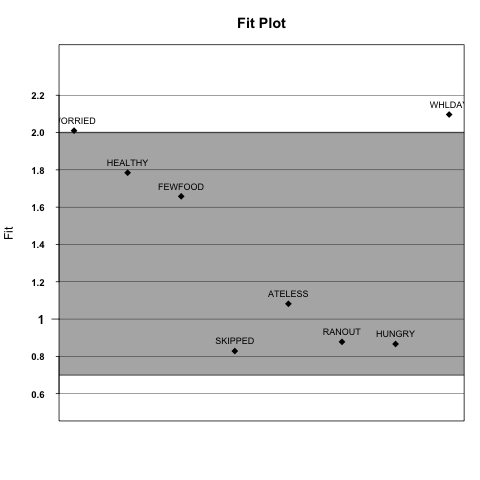

In [15]:
%%R
# # what about outfit?
outfit <- rr.ng$outfit


upper_bound <- rep(x = 2.0, times =8) # this repeats 1.33 fifteen times
lower_bound <- rep(x = .70, times = 8) 

fitgraph(fitEst = outfit, fitLB = lower_bound, fitUB = upper_bound, itemLabels = names(XX.ng))

**Inference**


An outfit of >2 is considered "high"
* **WORRIED and WHLDAY** items show the highest mean outfit of 2.01 and 2.09 respectively.
* Overall, the outfit statistics computed for the 2021 application of the FIES with the **MISC** do not indicate substantial model misfit or distortion of severity estimates for respondents to warrant any change in the estimation procedure

#### 3.0 Residual correlation matrix 

The Rasch model assumption that all correlations among items should result from
their common association with the latent trait is assessed by comparing residual correlations among items, after having eliminated the correlation that exists because the items contribute to measure the same latent trait. 

A residual correlation between a pair of items is considered high if it is >|0.4|

corrplot 0.92 loaded


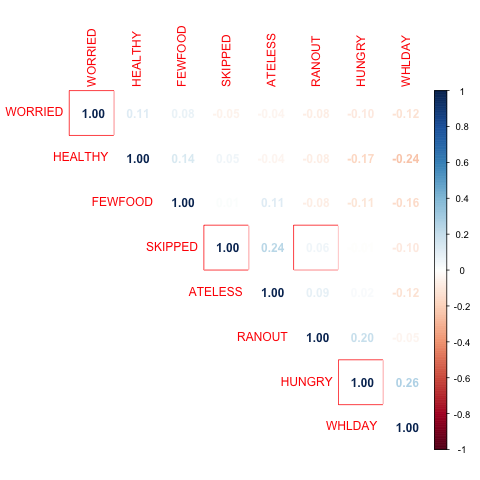

In [16]:
%%R
library(corrplot)
#  Residual correlation matrix 

# Set the threshold value for highlighting
threshold <- 0.4

cor_matrix <- rr.ng$res.corr

# Define colors for highlighting
highlight_color <- ifelse(abs(cor_matrix) > threshold, "red", "white")

# Plot the correlation matrix with highlighted values
corrplot(cor_matrix, method = "number", addgrid.col = highlight_color, type="upper")

**Inference**

Residual correlations were not found to be excessive(>|0.4|) for any pairs of items.

* Residual correlation between all pair of items is less than |0.4|
* Each item is seems to capture a different aspect of food insecurity, there are no redundant questions that would tend to weaken the ability to measure food insecurity accurately.

#### 4.0 Rasch Reliability 
Rasch reliability provides information about the discriminatory power of the overall scale,
measuring the proportion of variability in the data that is explained by the Rasch model. 

In [17]:
%%R
# Racsh model reliability analysis
rr.ng$reliab

# Rasch reliability based on equal proportion of cases in each
# non-extreme raw score (more comparable across datasets)
rr.ng$reliab.fl

[1] 0.756446


**Inference**

Mean Rasch reliability (flat), that is calculated given equal weight to each non-extreme raw score than than weighting by the proportion of cases in each raw score as in the standard statistic. The 'flat' statistics is more comparable acorss countries because it not sensitive to to the distribution of cases across raw scores, which may differ by country.

* The Rasch reliability value of 0.75 is greater than 0.7, considered acceptable. This level of reliability comprising of eight items reflect reasonable **good model fit**.

#### Calculate Insecurity prevalence 

This relative distribution can be used to calculate the food insecurity prevalence rates
at different levels. 

In [31]:
%%R

# First, one minus the cumulative distribution across all levels of raw score is calculated:

rv.ng=rowSums(XX.ng)
cbind("RS"=1:9,"Prev"=1-
cumsum(tab.weight(as.factor(rv.ng), wt.ng,
XX.ng)$RS.rel.w))[-9,]

     RS Prev
[1,]  1 0.81
[2,]  2 0.78
[3,]  3 0.75
[4,]  4 0.71
[5,]  5 0.65
[6,]  6 0.54
[7,]  7 0.41
[8,]  8 0.22


Setting a threshold of, for example, 4 to classify “moderate or severe” food
insecure, and of 7 to classify “severe” food insecure subjects (or households), will lead
to the following prevalence rates:

In [19]:
%%R

cbind("Threshold"=c(4,7),"Levels"=c("Mod. or severe",
"Severe"),
Prev=1-cumsum(tab.weight(as.factor(rv.ng), wt.ng,
XX.ng)$RS.rel.w)[c(4,7)])

     Threshold Levels           Prev  
[1,] "4"       "Mod. or severe" "0.71"
[2,] "7"       "Severe"         "0.41"


**Prevalence rates inference**

Prevalence Rate for "Moderate or Severe" Food Insecurity:
Threshold of 4: A score of 4 or higher is used to classify subjects or households as "moderate or severe" food insecure.
71% of the surveyed population has a food insecurity score of 4 or higher.

#### The probabilistic classification (or probabilistic assignment)

Performed by setting **thresholds** ( -0.25 and 1.83.) in terms of latent trait. The scale for each country is adjusted to the
global standard metric in order to derive comparable food insecurity prevalence rates.
The advantage of using this approach is that, after a procedure of equating, it can be used to calculate comparable
prevalence rates across countries. 


**_threshold_**

The lower threshold is specified at the level of severity associated with the item **“Ate less than should”** in the global reference scale (at about -0.3 units), while the higher threshold is specified at the severity level of the item **“Did not eat for a whole day”** (a value of about 2.0 on the global reference scale)

These threshold were specified by [VOH](https://openknowledge.fao.org/server/api/core/bitstreams/823b2fcd-bc52-4371-a31d-ea2aa74e63d5/content) with the objective of providing useful and meaningful prevalence statistics for monitoring food security over time in countries ranging from highly food secure to highly food insecure

_Page [18] FAO. 2016. Methods for estimating comparable rates of food insecurity experienced by adults throughout the world. Rome, FAO._

In [38]:
%%R

sthresh = c(-0.31, 1.88)
pp.ng = prob.assign(rr.ng, sthres = sthresh)$sprob

# # The probability of being beyond -0.25 on the latent trait in country 1 is
print(pp.ng[1]*100)

# # while the probability of being beyond 1.81 on the latent trait in country 1 is
print(pp.ng[2]*100)




[1] 66.58959
[1] 41.49495


## Summary

* The Rasch model reliabiliy of 0.75 percent is greater than 0.71 percent which is considered accepted for an 8 item FIES scale
* **WORRIED and WHLDAY** items show the highest mean outfit of 2.01 and 2.09 respectively. Overall, the outfit statistics computed for the 2021 application of the FIES with the **MISC** do not indicate substantial model misfit or distortion of severity estimates for respondents to warrant any change in the estimation procedure


### Overall Prevalence of FI according to the sixth-round MISC survey in Nigeria shows:

**Based on rawscore threshold:**

* 71% Prevalence Rate for "Moderate or Severe" Food Insecurity: Indicates a widespread issue where a significant majority of the population is struggling with food insecurity at a moderate or severe level.
* 41% Prevalence Rate for "Severe" Food Insecurity: Highlights a critical concern where a substantial portion of the population is facing severe food insecurity, necessitating urgent attention and intervention to address the more extreme challenges they are facing.

**Probabilistic classification**
By setting the thresholds in terms of latent trait:

* The resulting proportion of the sample population experiencing **moderate or severe FI** (FImod+sev) is 66.04%. 
* The proportion of the population experiencing **severe FI** (FIsev) is 42.37 %.



<hr>
<div>
    <a href="./1_hh_mics6_data_cleaning.ipynb">
        <button>&#8592; Data Cleaning Notebook</button>
    </a>
    <a href="./3_hh_mics6_eda.ipynb">
        <button style="float: right;">EDA Notebook &#8594;</button>
    </a>
</div>
<hr>